# Hidden Markov Models - Filtering

This notebook starts to dig into the `infer.py` module / portion of the `hmm` codebase. While the goal/mandate of the `dynamics` module was to simulate the underlying Markov dynamics and observations in a hidden markov model, the `infer.py` module acts to calculate probabilities of underlying (hidden) state values based on the sequence of observations.

In this notebook, we will focus on three probabilities:

$$ P(x_t | Y^t) \qquad \text{\sf Forward probability (Bayesian Filter)} $$
$$ P(x_t | Y^{[t+1, T]})\qquad \text{\sf Backwards probability} $$
$$ P(x_t | Y^T) \qquad\text{\sf Bayesian smoothed probability} $$

Here, the notation $P(x_t | Y^t)$ means that we are estimating the probability of the system being in state $x$ at time $t$, given the entire previous history (for $t=0,\cdots, t$) of observations. Similarly, $P(x_t|Y^{[t+1, T]})$ is an estimate of the same hidden state, but given all future probabilities. And finally, the $P(x_t | Y^T)$ term quantifies the best estimate of the hidden state at time $t$ using all information available (past and future).

The explicit details of these calculations are better covered in other supporting materials, but here we simply show how to calculate them from the infer module.

In [1]:
# First load in the necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='hls')

from hidden_py import dynamics, infer


# initialise the HMM
hmm = dynamics.HMM(2, 2)
hmm.init_uniform_cycle(trans_rate=0.1, error_rate=0.2)

# run the HMM dynamics
hmm.run_dynamics(500)

# And fetch the states and observations
state_ts = hmm.state_ts
obs_ts = hmm.obs_ts

In [2]:
# Now, we can create an instance of the MarkovInfer object contained in the 
# infer module, which does all of the heavy-lifting for the inferrence routines
analyzer = infer.MarkovInfer(2, 2)

# Now, to calculate the forward probabilities, we simply run the
# `forward_algo(...)` routine, which requires as input the observations, as
# well as the transition and observation matrices. Later, we will discuss what
# to do when you don't know what those matrices are, but for now, we'll just
# use the 'true' values used to generate the dynamics
analyzer.forward_algo(obs_ts, hmm.A, hmm.B)

In [3]:
# Now, we can look at the forward probabilities, which will be a list of
# 2-state probability vectors, containing the conditional confidence in each
# state
# here are the first 10 entries
analyzer.forward_tracker[:10]

array([[0.2       , 0.8       ],
       [0.08074534, 0.91925466],
       [0.0469442 , 0.9530558 ],
       [0.03834473, 0.96165527],
       [0.03621862, 0.96378138],
       [0.03569671, 0.96430329],
       [0.03556882, 0.96443118],
       [0.03553749, 0.96446251],
       [0.3708393 , 0.6291607 ],
       [0.14116493, 0.85883507]])

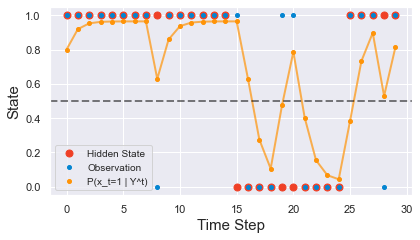

In [9]:
# Using this information, we can plot the probability that the system is in
# state 1 along with the true states and observations to understand how it is
# working

prob_1 = [p[1] for p in analyzer.forward_tracker]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(state_ts[:30], 'o', markersize=7, color=sns.xkcd_rgb["tomato"], label="Hidden State")
ax.plot(obs_ts[:30], 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], label="Observation")
ax.plot(prob_1[:30], linewidth=2.0, alpha=0.7, color=sns.xkcd_rgb["tangerine"])
ax.plot(prob_1[:30], 'o', markersize=4, color=sns.xkcd_rgb["tangerine"], label="P(x_t=1 | Y^t)")
ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k', alpha=0.5)
ax.legend(fontsize=10, frameon=True)
ax.set_xlabel(r"Time Step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
plt.tight_layout()
plt.show()


In [10]:
# We can then say that, whenever P(x_t = 1 | Y^t) > 0.5, we estimate that the
# hidden state is x_t = 1 to generate a list of 'filtered predictions'

filter_predictions = [int(p[1] > 0.5) for p in analyzer.forward_tracker]

In [11]:
# And we can calculate the error rate assocaited with the filter prediction,
# as compared to the naive prediction (this could also quantified through
# something known as the 'discord' order parameter)

error_naive = len(list(filter(lambda x: x[0] != x[1], zip(obs_ts, state_ts)))) / len(state_ts)
error_filter = len(list(filter(lambda x: x[0] != x[1], zip(filter_predictions, state_ts)))) / len(state_ts)

print(f"Naive Error  -- {error_naive}")
print(f"Filter Error -- {error_filter}")

Naive Error  -- 0.238
Filter Error -- 0.192


In [7]:
# So, we can see that the probabilistic filter does a better job at predicting
# the hidden state than the naive estimate.

In [13]:
# Next, we can calculate the backwards probability in a similar way, using the
# backwards_algo(...) routine
analyzer.backward_algo(obs_ts, hmm.A, hmm.B)

# And also the bayesian smoothed estimate, from from the `bayesian_smooth`
# routine (which assumes that the forward and backward algorithms have already
# # been run)
analyzer.bayesian_smooth(obs_ts, hmm.A, hmm.B)

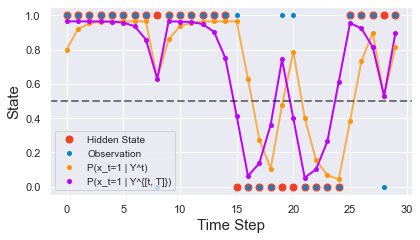

In [14]:
# Now, we can first add the backwards probability to the previous plot

prob_1_back = [p[1] for p in analyzer.backward_tracker]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(state_ts[:30], 'o', markersize=7, color=sns.xkcd_rgb["tomato"], label="Hidden State")
ax.plot(obs_ts[:30], 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], label="Observation")
ax.plot(prob_1[:30], linewidth=2.0, alpha=0.7, color=sns.xkcd_rgb["tangerine"])
ax.plot(prob_1_back[:30], linewidth=2.0, color=sns.xkcd_rgb["bright purple"])
ax.plot(prob_1[:30], 'o', markersize=4, color=sns.xkcd_rgb["tangerine"], label="P(x_t=1 | Y^t)")
ax.plot(prob_1_back[:30], 'o', markersize=4, color=sns.xkcd_rgb["bright purple"], label="P(x_t=1 | Y^{[t, T]})")

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k', alpha=0.5)
ax.legend(fontsize=10, frameon=True)
ax.set_xlabel(r"Time Step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
plt.tight_layout()
plt.show()


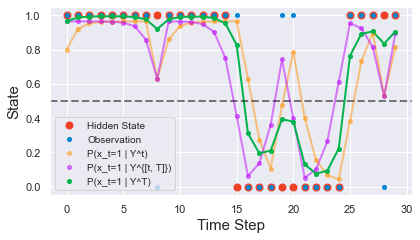

In [16]:
# and finally, the full bayesian probability

prob_1_bayes = [p[1] for p in analyzer.bayes_smooth]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(state_ts[:30], 'o', markersize=7, color=sns.xkcd_rgb["tomato"], label="Hidden State")
ax.plot(obs_ts[:30], 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], label="Observation")
ax.plot(prob_1[:30], linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.5)
ax.plot(prob_1_back[:30], linewidth=2.0, color=sns.xkcd_rgb["bright purple"], alpha = 0.5)
ax.plot(prob_1_bayes[:30], linewidth=2.0, color=sns.xkcd_rgb["shamrock"])

ax.plot(prob_1[:30], 'o', markersize=4, color=sns.xkcd_rgb["tangerine"], label="P(x_t=1 | Y^t)", alpha = 0.5)
ax.plot(prob_1_back[:30], 'o', markersize=4, color=sns.xkcd_rgb["bright purple"], label="P(x_t=1 | Y^{[t, T]})", alpha = 0.5)
ax.plot(prob_1_bayes[:30], 'o', markersize=4, color=sns.xkcd_rgb["shamrock"], label="P(x_t=1 | Y^T)")

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k', alpha=0.5)
ax.legend(fontsize=10, frameon=True)
ax.set_xlabel(r"Time Step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
plt.tight_layout()
plt.show()


In [17]:
# Now, we can also calculate the errors on these two other filters to see
# how they all compare:

back_predictions =  [int(p[1] > 0.5) for p in analyzer.backward_tracker]
bayes_predictions =  [int(p[1] > 0.5) for p in analyzer.bayes_smooth]

error_back = len(list(filter(lambda x: x[0] != x[1], zip(back_predictions, state_ts)))) / len(state_ts)
error_bayes = len(list(filter(lambda x: x[0] != x[1], zip(bayes_predictions, state_ts)))) / len(state_ts)


print(f"Error -- Naive    : {error_naive}")
print(f"Error -- Forward  : {error_filter}")
print(f"Error -- Backward : {error_back}")
print(f"Error -- Bayesian : {error_bayes}")

Error -- Naive    : 0.238
Error -- Forward  : 0.192
Error -- Backward : 0.226
Error -- Bayesian : 0.176


In [18]:
# Here, we can see that the bayesian smoother has the lowest error of all of the
# methods, as expected.